In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import paddle

# 1 数据读入

## 1.1 数据整理

In [4]:
#读取训练文件数据
txt_path='./data/train_dataset.csv'
#读取训练数据文件
data=pd.read_csv(txt_path,encoding='utf-8',sep='|')
#打印查看数据样例
data.head(5)

,id,content
0,25001,【坐席】您好，实习话务员为您服务，【客户】，唉，你好那个，我刚收到咱们那个话费通知的短信了，...
1,25002,【坐席】您好，很高兴为您服务，【客户】，嗯，你好，那个先说一下那个不太好意思，因为今天不是我...
2,25003,【坐席】您好，很高兴为您服务，您好，【客户】，那个我这个套餐到期了也没人通知我呀，我原来是1...
3,25004,【坐席】很高兴为您服务，您好？【客户】，唉，你好，我想问一下我那个话费现在欠了多少了？【坐席...
4,25005,【坐席】您好，很高兴为您服务，【客户】，唉，你好，你帮我查一下，我有一个业务是返返钱的业务，...


### 1.1.1 大体分析

In [5]:
#计算最大的内容和摘要长度
def max_text_len(self):
    for i, col in enumerate(self):
        data[col] = data[col].astype(str)
        n_max = data[col].str.len().max()
        print(i, col, n_max)

In [6]:
#计算平均的内容和摘要长度
def avg_text_len(self):
    for i, col in enumerate(self):
        data[col] = data[col].astype(str)
        n_mean = data[col].str.len().mean()
        print(i, col, n_mean)

In [7]:
content_np = np.array(data['content'].astype(str).str.len())
content_np.shape
content_np = np.sort(content_np)

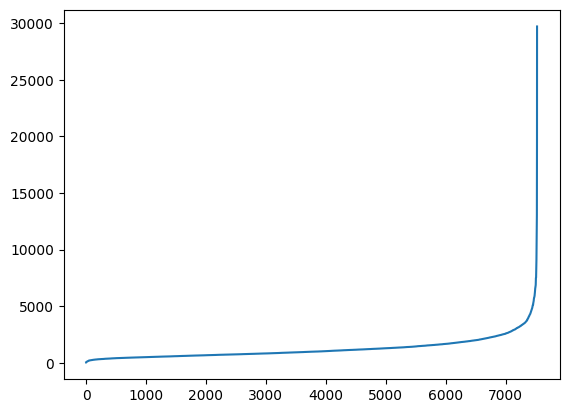

In [8]:
plt.plot(content_np[0:25000])

In [9]:
abstract_np = np.array(data['abstract'].astype(str).str.len())
abstract_np.shape
abstract_np = np.sort(abstract_np)

KeyError: 'abstract'

In [ ]:
plt.plot(abstract_np[0:25000])

In [10]:
#查看最大的内容和文本长度
print(max_text_len(data.columns.tolist()))

0 id 5
1 content 29723
None


In [11]:
print(avg_text_len(data.columns.tolist()))

0 id 5.0
1 content 1236.5745415891577
None


1. 可以观察到输入的均值达到了1215，而输出的摘要的均值达到了105左右，估计实际上排除一些极端情况，输出摘要设置为100即可，但是受限于模型，输入长度必须为小于512。
2. 考虑手工的去分析一下数据输入输出。

### 1.1.2 手工分析

1. 基于分词的分析：在其他地方做了，跑一遍太慢因此这里就直接看看结果
Top 50 Words： 
[('，', 2538404), ('【', 868249), ('】', 868137), 
('我', 793305), ('的', 717029), ('您', 666833), ('坐席', 442013), ('客户', 427701), ('是', 354202), ('这个', 344599), ('了', 315043), ('嗯', 294789), 
('？', 276643), ('给', 233060), ('那', 213093), ('就', 171916), ('那个', 169981), ('你', 166167), ('一下', 153895), ('就是', 153297), ('说', 139719), 
('这', 136215), ('话', 133796), ('啊', 123020), ('这边', 121748), ('对', 114818), ('吧', 113453), ('有', 108422), ('然后', 105621), ('现在', 99306),
 ('吗', 98498), ('一个', 86197), ('流量', 83435), ('没有', 83111), ('呢', 81668), ('帮', 81326), ('*', 80929), ('它', 77542), ('都', 75986), 
 ('可以', 69961), ('在', 67182), ('他', 66476), ('好', 65854), ('先生', 65332), ('问题', 65299), ('你们', 64301), ('也', 57603), ('用', 57591), ('看', 56235),
  ('电话', 53469)]
2. 比如如下操作
    - 可以看一看具体数据，首先有些词语需要进行替换，比如“坐席”，“客户”，可以考虑换成一个特殊词语或者换成特殊字符
    - 对于具体数据中的第一句话大多为“您好...为您服务”之类的，这种句子完全无用，因此可以考虑全部去除掉
    - 一些语气词比如“啊”，“唉”，“哦”，“噢”等
    - 一些发语句子，比如“我想问一下”，“然后...”，“您好”，“你好”等
    - 最为重要的是要限制句子长度小于512，因此会有几个方法，比如考虑头尾，忽略中间。等方式

In [12]:
data.head(10)

,id,content
0,25001,【坐席】您好，实习话务员为您服务，【客户】，唉，你好那个，我刚收到咱们那个话费通知的短信了，...
1,25002,【坐席】您好，很高兴为您服务，【客户】，嗯，你好，那个先说一下那个不太好意思，因为今天不是我...
2,25003,【坐席】您好，很高兴为您服务，您好，【客户】，那个我这个套餐到期了也没人通知我呀，我原来是1...
3,25004,【坐席】很高兴为您服务，您好？【客户】，唉，你好，我想问一下我那个话费现在欠了多少了？【坐席...
4,25005,【坐席】您好，很高兴为您服务，【客户】，唉，你好，你帮我查一下，我有一个业务是返返钱的业务，...
5,25006,【客户】喂，【坐席】，您好，有什么可以帮您【客户】你好，我想投诉一下，就是我们这个楼信号特别...
6,25007,【坐席】您好，很高兴为您，【客户】喂，唉，你好是这样，就是我那个手机的流量封顶了嘛，他就说开...
7,25008,【坐席】您好很高兴为您服务【客户】那个请帮我查一下我的话费和流量我这个流量上个月流转五个G怎...
8,25009,【坐席】您好，很高兴为您服务【客户】，你好，嗯，那个不需要？【坐席】帮到您的吗？【客户】就是...
9,25010,【坐席】很高兴服务，您好，唉，您好？【客户】，唉，你好，我这个要我这手机号是那个冰激凌套餐，...


## 1.2 数据清理

### 1. 首先清理第一句话

$\qquad$根据观察，第一句话大多是来自【坐席】的问候语句，没有实质的意义。但也有小部分的情况，第一句话来自【客户】，故首先统计一下第一句话是【客户】的情况并观察其内容，排除影响。

In [13]:
all_conts = []

In [14]:
cont = data['content']
cont = cont.str.replace('【','\【')
client_front_conts = []
for sen in cont:
    cut = sen.split("\\")[1:]
    all_conts.append(cut)
    if cut[0][1:3] == "客户":
        client_front_conts.append(cut[0] + cut[1])

In [15]:
all_conts[0]

['【坐席】您好，实习话务员为您服务，',
 '【客户】，唉，你好那个，我刚收到咱们那个话费通知的短信了，我看了一下说我上个月消费了二十一块多吧，然后有五元是我的包月费，然后剩下有16块多的那个其他的消费，我这个没有进行过任何的，就是上网啊，通话的，我想查查那个什么费用啊，',
 '【坐席】嗯，稍等我看一下1月啊，二十一块8，上网流量费，15块9毛3，国内通话费0.15元，到达电话打了一分钟流量的话，应该是超出了一部分，用了15块9毛3的流量费，',
 '【客户】对，我这个肯定没有用流量，因为我这个是退休在家，我家里有WIFI，我也不出去玩，一星之前我刚激活，根本连买菜都不用，我出去就是这个，这个流量是怎么出来的钱啊，你们这肯定有积分问题，',
 '【坐席】用了五十五十九兆流量，然后扣了19块15块9毛7的费用',
 '【客户】59兆流量六块钱，',
 '【坐席】电话那您对流量超出不认可的话可以给您进行上报反馈，后期会有专人给您回电处理，',
 '【客户】嗯，他最后给我回电，怎么处理呀？我要求这返就是返费，因为我肯定没消费这个，比如说电话电话有过吗？你使过我电话吗？电话我也没打过呀，我家里人也没用，我电话打过，我们每个人都有手续啊，',
 '【坐席】现在这边无法给您进行核实，只能看到您使用的超出，嗯，您是没有使用的话，我这边给您记录上报，后期会有专人给您',
 '【客户】你你给我上报余额，实际话费，反正就这15块几吧，我肯定没花点钱，我肯定要交的，但是这个我我绝对没用过，因为我就没出过门激活，',
 '【坐席】好，那我这边给您记录上报，后期会有专人给您回复，保持电话畅通啊，',
 '【客户】嗯，他什么时候联系我呀？还是直接就给我发短信，',
 '【坐席】嗯，24小时，你回复电话，',
 '【客户】噢噢，行好了行，谢谢唉，',
 '【坐席】嗯，那感谢您来电，稍后按两个一，谢谢',
 '【客户】嗯']

In [16]:
client_front_conts

['【客户】喂，【坐席】，您好，有什么可以帮您',
 '【客户】您好高兴服务，我答你们这电话达多少次了？投诉了多少？就是跟你们反映了多少次，就这个附近这个基站，为什么这个网络为什么老是还不好呀【坐席】？嗯，就是信号打的网络是吗？这个位置嗯，对，好的，我查一下？',
 '【客户】喂你好，【坐席】，高兴服务，唉，你好？',
 '【客户】喂你好？【坐席】，您好，嗯，您好，我是北京联通回访员，就您在4月2号的时候对永泰中路营业厅评价的差评，请问您认为我公司还有哪些方面需要改进的呢，',
 '【客户】嗯，【坐席】，您好，很高兴为您服务？',
 '【客户】看到那个网上，然后呢，【坐席】您好，',
 '【客户】反映过【坐席】，为您服务，',
 '【客户】您好，【坐席】，您好，很高兴为您服务，',
 '【客户】您好，很高兴为您服务。【坐席】唉，你好，我想装一下宽带。',
 '【客户】你好，【坐席】，您好，很高兴为您服务，您好？',
 '【客户】好，【坐席】，好',
 '【客户】嗯，【坐席】，您好，实习话务员为您服务',
 '【客户】高兴服务您好，【坐席】，嗯，您好，这里是北京移动客服中心，请问，',
 '【客户】唉，我这个申请了一个免提啊，嗯，喂？【坐席】，嗯，您好女士，有什么可以帮您的，',
 '【客户】你好问一下，我这某某人卡是在那个山东青岛平陆办的，为什么会是一某某人北京卡，山东省，然后平度市不是不是，当时是工作人员给我上门办的，嗯，对什么？那当时你们给我打电话，我就是在平陆申请的，当时给我打电话的时候，我还问过我说是当地的吗？我不是的话我就不要了，他告诉我是，然后我今天开始用了，我发现她是北京的，然后我现在这个卡也没返微信，也不能用这某某人卡已经被注册过了这个号码，【坐席】对',
 '【客户】喂你好我问一下这个大兴这边网络是怎么回事啊【坐席】包含手机',
 '【客户】嗯【坐席】，很高兴为您服务，',
 '【客户】嗯，【坐席】，您好，很高兴为您服务',
 '【客户】您好实习话务员，【坐席】为您服务',
 '【客户】喂你好？【坐席】，唉，您好，打扰您了，北京联通的这边看到您有通过我们在线客服来访反映要退订流量包是吗，',
 '【客户】喂你好，【坐席】，您好，我是北京联通客服中心的，工号31692，',
 '【客户】您好，很高兴为您，【坐席】您服务',
 '【客户】还有【坐席】为

In [17]:
len(client_front_conts)

551

In [18]:
t = 0
for sen in client_front_conts:
    re_sen = sen.replace('【','\【')
    cut = re_sen.split("\\")[1:]
    if len(cut[0]) <= 25:
        t += 1
        print(sen)

【客户】喂，【坐席】，您好，有什么可以帮您
【客户】喂你好，【坐席】，高兴服务，唉，你好？
【客户】喂你好？【坐席】，您好，嗯，您好，我是北京联通回访员，就您在4月2号的时候对永泰中路营业厅评价的差评，请问您认为我公司还有哪些方面需要改进的呢，
【客户】嗯，【坐席】，您好，很高兴为您服务？
【客户】看到那个网上，然后呢，【坐席】您好，
【客户】反映过【坐席】，为您服务，
【客户】您好，【坐席】，您好，很高兴为您服务，
【客户】您好，很高兴为您服务。【坐席】唉，你好，我想装一下宽带。
【客户】你好，【坐席】，您好，很高兴为您服务，您好？
【客户】好，【坐席】，好
【客户】嗯，【坐席】，您好，实习话务员为您服务
【客户】高兴服务您好，【坐席】，嗯，您好，这里是北京移动客服中心，请问，
【客户】唉，我这个申请了一个免提啊，嗯，喂？【坐席】，嗯，您好女士，有什么可以帮您的，
【客户】喂你好我问一下这个大兴这边网络是怎么回事啊【坐席】包含手机
【客户】嗯【坐席】，很高兴为您服务，
【客户】嗯，【坐席】，您好，很高兴为您服务
【客户】您好实习话务员，【坐席】为您服务
【客户】喂你好？【坐席】，唉，您好，打扰您了，北京联通的这边看到您有通过我们在线客服来访反映要退订流量包是吗，
【客户】喂你好，【坐席】，您好，我是北京联通客服中心的，工号31692，
【客户】您好，很高兴为您，【坐席】您服务
【客户】还有【坐席】为您服务，请讲，
【客户】嗯【坐席】，您好，很高兴服务，您好，那个您帮我查一下，我这个手机通话异常啊，有我查，我今天那个手机话费没钱了，然后我看了有一个记录显示是我2月9号从四点多开始到第二天，嗯，上午10点钟六点，一直在打同一个电话，打了15个小时
【客户】感谢来电，【坐席】，您好，实习话务员为您服务，
【客户】我这个手机，【坐席】您服务，
【客户】嗯。【坐席】您好，很高兴为您服务。
【客户】您好。【坐席】就是话务员。
【客户】你好，【坐席】，您好，我是北京联通的回访员，您好，1月份办理了5G升级包业务，会给您提供优质服务，占用您一点时间再办理情况，做个回访好吧，
【客户】喂你好，【坐席】，嗯，实习话务员为您服务
【客户】喂？【坐席】，唉，您好，我这边的话是北京联通，您现在方便接听吗，
【客户】喂，你大点声行吗？【坐席】？请问可以听到吗，
【客户】嗯，【坐席】，您好，很

In [19]:
t

386

In [20]:
for sen in client_front_conts:
    re_sen = sen.replace('【','\【')
    cut = re_sen.split("\\")[1:]
    if len(cut[0]) > 25:
        print(sen)

【客户】您好高兴服务，我答你们这电话达多少次了？投诉了多少？就是跟你们反映了多少次，就这个附近这个基站，为什么这个网络为什么老是还不好呀【坐席】？嗯，就是信号打的网络是吗？这个位置嗯，对，好的，我查一下？
【客户】你好问一下，我这某某人卡是在那个山东青岛平陆办的，为什么会是一某某人北京卡，山东省，然后平度市不是不是，当时是工作人员给我上门办的，嗯，对什么？那当时你们给我打电话，我就是在平陆申请的，当时给我打电话的时候，我还问过我说是当地的吗？我不是的话我就不要了，他告诉我是，然后我今天开始用了，我发现她是北京的，然后我现在这个卡也没返微信，也不能用这某某人卡已经被注册过了这个号码，【坐席】对
【客户】您好很高兴为您服务你好我想问一下就是我这从十一月份到今年十月份话费怎么用的这么高【坐席】去年十一月份二零二零年十一月份到现在啊
【客户】那个我问一下我，我我那什么，刚才我还有欠费多少钱了，【坐席】？您目前是有这个1月份未结清的，16块2毛4，再加上本月2月份的话费，交了就行？
【客户】稍等我这里，我这有个问题啊，我刚才那个在那个APP上办理了一个套餐的一个变更，从这个109变成1129完了，不是下个月生效吗？但是我变更完了以后，我的手机这个信号突然间就没了，然后有了以后就变成一格，到现在一直都是一格手机关机，重启了好多次了，也一直都这样【坐席】，您这目前操作的话就收到短信吧现在
【客户】喂你好，那个，我想我想问你一下，我这个我这个怎么没去过，我就去过这个北京跟河北交界的，但还是北京地区，它有个修理厂，我就答了一回信，然后我这健康嘛就就就变了，新城嘛就变了，这这怎么弄啊，【坐席】？您好，中国联通，
【客户】你好，我想问一下我这个手机怎么从昨天，嗯，就就从今天某某人的时候突然没4G网了，对上不了网了现在【坐席】手机上面有信号吗？先生，
【客户】你好，帮我查一下我这个，我这我这手机号码，现在，唉，我这个手机号码昨天就被禁用了，什么情况？【坐席】？嗯，好给您看一下，稍等，您是近期用这个打了很多电话吗，
【客户】您好，请问什么可以帮您？唉，你好我这个手机号呀，现在他说我欠费停机了，打不了电话了，我是包年的那种，我交过费了呀，【坐席】，嗯，稍等我看一下就突然给您发短信提示是吧嗯
【客户】您好，很高兴为您服务，喂，你好，那个我现在收不到，咱们那个就是联通的这个短信呢，【坐席】，是的先

结论1：对于以【客户】开头的数据，存在4种语言情况：

（1）标注错误。许多以【客户】开头的长句中，都包含了【坐席】的第一句话“您好，很高兴为您服务”等字眼，但这些内容没有被区分出来，而是被一股脑塞进了【客户】的语句中。这类语句的第一句长度一般大于25，不需要去除，“您好”等错误混入的语句可以通过后面的关键词筛除步骤去除；第二句不需要去除。

（2）用户直接抛出问题。用户没有等【坐席】说出基本的问候语就直接抛出问题，【坐席】紧接着进行询问和解决。这类语句的第一句长度一般大于25，不需要去除；第二句不需要去除。

（3）回访电话。回访电话是由通话公司打给用户的，因此第一句一般是用户的“喂”“你好”等回应。这类语句的第一句长度一般小于25，需要去除；第二句说明主要问题，语句长度大于20，不需要去除。

（4）互相问候。【客户】和【坐席】彼此问候，语句都比较短，基本没有实质意义。第一句和第二句都需要去除。

基于上述4种语言情况，需要做的处理为：对于以【客户】开头的数据，（1）先判断第一句长度是否大于25，是则不用去除任何内容；否则去除第一句，并进行下一步筛选。（2）判断第二句长度是否大于20，是则不用去除；否则去除第二句。

In [21]:
for i in range(len(all_conts)):
    each_cont = all_conts[i]
    if len(each_cont[0]) <= 25:
        each_cont = each_cont[1:]
        if len(each_cont[0]) <= 20:
            each_cont = each_cont[1:]
    all_conts[i] = ("".join(each_cont))

In [22]:
data['content'] = all_conts

In [23]:
content_np = np.array(data['content'].astype(str).str.len())
content_np.shape
content_np = np.sort(content_np)
print(content_np.mean()) 

1220.5927451501461


### 2. 词组替换

In [24]:
# 词组替换
replace_dict = {
    "？":"，",
    "。":"，",
    '您好，':'',
    '您好？':'',
    '你好，':'',
    '你好?':'',
    '你好':'',
    '喂':'',
    '然后':'',
    '而且':'',
    '那个':'',
    '这个':'',
    '一个':'',
    "我我":'我',
    "你你":'你',
    "您您":'您',
    "先生":'',
    "女士":'',
    "很高兴为您服务，":'',
    "高兴为您服务，":'',
    "高兴为您服务？":'',
    "其他可以帮您":"",
    "其他可以帮到您":"",
    "还有其他":"",
    "什么可以帮您":"",
    "其他需要帮助的":"",
    "听不太清":'',
    "高兴":'',
    "嗯":'',
    "噢":'',
    "哦":'',
    "呀":'',
    "啊":'',
    "呢":'',
    "就是":'',
    "稍等":'',
    "为您":'',
    "话务员":'',
    "实习":'',
    "很服务":'',
    "唉":"",
    "您好":"",
    "我方客户":'',
    "客户我方":'',
    "我方，":"我方",
    "我方。":"我方",
    "客户。":"客户",
    "客户，":"客户",
    "，，":"",
    "********":"*",
    "*******":"*",
    "******":"*",
    "*****":"*",
    "****":"*"
}
aa = data['content']
for i,j in replace_dict.items():
    aa = aa.str.replace(i,j)

In [25]:
data['content'] = aa

### 3. 去除过短的句子

根据对数据的观察和经验，大部分字数少于6个字的语句都是无意义的语句，可以被去除。

In [26]:
all_conts = []

In [27]:
cont = data['content']
cont = cont.str.replace('【','\【')
all_conts = [sen.split("\\")[1:] for sen in cont]

In [28]:
all_conts[:5]

[['【客户】，我刚收到咱们话费通知的短信了，我看了一下说我上个月消费了二十一块多吧，有五元是我的包月费，剩下有16块多的其他的消费，我没有进行过任何的，上网，通话的，我想查查什么费用，',
  '【坐席】，我看一下1月，二十一块8，上网流量费，15块9毛3，国内通话费0.15元，到达电话打了一分钟流量的话，应该是超出了一部分，用了15块9毛3的流量费，',
  '【客户】对，我肯定没有用流量，因为我是退休在家，我家里有WIFI，我也不出去玩，一星之前我刚激活，根本连买菜都不用，我出去，流量是怎么出来的钱，你们这肯定有积分问题，',
  '【坐席】用了五十五十九兆流量，扣了19块15块9毛7的费用',
  '【客户】59兆流量六块钱，',
  '【坐席】电话那您对流量超出不认可的话可以给您进行上报反馈，后期会有专人给您回电处理，',
  '【客户】，他最后给我回电，怎么处理，我要求这返返费，因为我肯定没消费，比如说电话电话有过吗，你使过我电话吗，电话我也没打过，我家里人也没用，我电话打过，我们每个人都有手续，',
  '【坐席】现在这边无法给您进行核实，只能看到您使用的超出您是没有使用的话，我这边给您记录上报，后期会有专人给您',
  '【客户】你给我上报余额，实际话费，反正就这15块几吧，我肯定没花点钱，我肯定要交的，但是我绝对没用过，因为我就没出过门激活，',
  '【坐席】好，那我这边给您记录上报，后期会有专人给您回复，保持电话畅通，',
  '【客户】，他什么时候联系我，还是直接就给我发短信，',
  '【坐席】，24小时，你回复电话，',
  '【客户】，行好了行，谢谢，',
  '【坐席】，那感谢您来电，稍后按两个一，谢谢',
  '【客户】'],
 ['【客户】先说一下不太好意思，因为今天不是我，因为之前投诉，不是你们扣费的问题吗，今天今天应该给我反馈回来了，有服务电话，我没记住，这件事情不好，因为比较忙，我当时没有就没有借助你这这卡，很抱歉的，我，我可能出现出来，我楚是什么事，',
  '【坐席】那我给您看看，一下，',
  '【客户】，是这样的，你这今天是我做就做两次，对',
  '【坐席】就当时联系，您能联系到您之前反映过流量问题，但是之前事处理部门有处理方案咱们出于服务角度，可以给您适当的给您减一下11月和12月份的流量费用，您考虑一下，',


In [29]:
def delete_short(x):
    return len(x) > 6

for i in range(len(all_conts)):
    dialogue = all_conts[i]
    part_sent = ""
    for part in dialogue:
        sent = part[4:]
        sent = sent.replace('。','，')
        sent = sent.replace('？','，')
        sents = sent.split('，')
        sents = filter(delete_short, sents)
        join_sen = "，".join(sents)
        if join_sen != '':
            part_sent += part[:4] + join_sen
    all_conts[i] = part_sent

In [30]:
all_conts[:10]

['【客户】我刚收到咱们话费通知的短信了，我看了一下说我上个月消费了二十一块多吧，有五元是我的包月费，剩下有16块多的其他的消费，我没有进行过任何的，我想查查什么费用【坐席】国内通话费0.15元，到达电话打了一分钟流量的话，应该是超出了一部分，用了15块9毛3的流量费【客户】我肯定没有用流量，因为我是退休在家，我家里有WIFI，一星之前我刚激活，根本连买菜都不用，流量是怎么出来的钱，你们这肯定有积分问题【坐席】用了五十五十九兆流量，扣了19块15块9毛7的费用【客户】59兆流量六块钱【坐席】电话那您对流量超出不认可的话可以给您进行上报反馈，后期会有专人给您回电处理【客户】他最后给我回电，我要求这返返费，因为我肯定没消费，比如说电话电话有过吗，你使过我电话吗，电话我也没打过，我家里人也没用，我们每个人都有手续【坐席】现在这边无法给您进行核实，只能看到您使用的超出您是没有使用的话，我这边给您记录上报，后期会有专人给您【客户】你给我上报余额，反正就这15块几吧，我肯定没花点钱，但是我绝对没用过，因为我就没出过门激活【坐席】那我这边给您记录上报，后期会有专人给您回复【客户】他什么时候联系我，还是直接就给我发短信',
 '【客户】先说一下不太好意思，因为今天不是我，不是你们扣费的问题吗，今天今天应该给我反馈回来了，我当时没有就没有借助你这这卡，我可能出现出来【客户】你这今天是我做就做两次【坐席】您能联系到您之前反映过流量问题，但是之前事处理部门有处理方案咱们出于服务角度，可以给您适当的给您减一下11月和12月份的流量费用【坐席】那我再去给您登记报一下，让处理部门尽快联系您【客户】为什么得时间显示秒给我订的不是这这今天又有事，被不住你们的没错【坐席】可能您那忙没您这当时【客户】我去营业厅确认是，有没有确定申请停机，好像是我原先不好意思，我也不知道怎么联系你，只能这么怎么联系【坐席】我再给您报完再处理部门再回想一下【客户】你这这这这给人说【坐席】我去给您催一下【客户】你一点事一点对不对，感觉无人答我电话我都没我都我都没接到，这这有点说不过去了，你说我这刚买完，赶紧赶紧给我回【坐席】那我让处理部门再和您沟通事情好吧【坐席】那报一下那没关系【坐席】好好的感谢来电好再见',
 '【客户】我套餐到期了也没人通知我，我原来是138块6的，现在它我这刚发现了，现在是按198了【坐席】这边帮您

In [31]:
data['content'] = all_conts

content_np = np.array(data['content'].astype(str).str.len())
content_np.shape
content_np = np.sort(content_np)
print(content_np.mean()) # 均值减少了快100多

819.8927717246878


### 3. 替换词组

In [32]:
# 词组替换
replace_dict = {
    "【坐席】":"坐:",
    "【客户】":"客:"
}
aa = data['content']
for i,j in replace_dict.items():
    aa = aa.str.replace(i,j)
aa[175:185]

175    客:我这流量扣的是不是不对，我从昨天到现在都没咋用手机怎么又扣了六个G坐:现在流量没有使用过...
176    客:您帮我查一下我那号码欠费欠的什么费用坐:来电手机号的话目前83块5毛5，费用它话您可以正...
177    客:请帮我查一下我最近两个月的消费情况和，是1月份和12月份的坐:您是12月份的话，除了19...
178    客:我流量月是不是用完了坐:您月还有60个G客:月还有60个G我的网速那么慢呐卡坐:您把手机...
179    客:帮我看一下我这手机为什么经常接不到电话客:有的电话能接到，有的电话就接不到，但是我并没有...
180    客:能看到我有多少积分吗，我看我的积分咋没了坐:应该是之前在您身份证名下有欠费的消耗的情况客...
181    客:我手机电话好长时间没用了，昨天下午刚用了，怎么今天就给我停机了客:这好长时间没用，昨天下...
182    客:我这现在新城马查不出来坐:验证码查不到是吗，今天一天都查不到吗客:弄一天了也没查出来坐:...
183    客:你帮我看一下我套餐都有什么套餐坐:您这边帮您看一下，是月租57的沃派校园套餐，包含200...
184    客:是不是月就到期可以更改套餐了坐:我帮您查一下目前我这帮您看了一下您手机号靓号低消活动的话...
Name: content, dtype: object

In [33]:
content_np = np.array(aa.astype(str).str.len())
content_np.shape
content_np = np.sort(content_np)
print(content_np.mean()) # 均值减少了快100多

770.9799362211002


In [34]:
data['content'] = aa

In [35]:
data.head(10)

,id,content
0,25001,客:我刚收到咱们话费通知的短信了，我看了一下说我上个月消费了二十一块多吧，有五元是我的包月费...
1,25002,客:先说一下不太好意思，因为今天不是我，不是你们扣费的问题吗，今天今天应该给我反馈回来了，我...
2,25003,客:我套餐到期了也没人通知我，我原来是138块6的，现在它我这刚发现了，现在是按198了坐:...
3,25004,客:我想问一下我话费现在欠了多少了坐:来电这号码欠费了多少钱是吗客:看他这是什么套餐坐:它是...
4,25005,客:我有业务是返返钱的业务，一放有的1月份的时候给我返了个九十九十九，月好像还能返28客:我...
5,25006,客:我们楼信号特别差坐:是上不去网还是打不了电话那麻烦您说一下，您现在所在信号不好的地址客:...
6,25007,客:我手机的流量封顶了嘛坐:我会帮您反映修改后的服务密码吗坐:我给您转到语音台，我这边帮您把...
7,25008,客:请帮我查一下我的话费和流量我流量上个月流转五个G怎么现在我怎么流量不够了另外那电话给我欠...
8,25009,客:刚才我找寻他买的时候发现我这提示音您注意长，能帮我查一下什么原因吗坐:这给您查不出来的客...
9,25010,客:我要我这手机号是冰激凌套餐，怎么我网就几乎上不上什么情况坐:您是说手机现在上不了网是吗坐...


In [36]:
for sen in data['content'][30:40]:
    print(sen)

客:麻烦你帮我看一下我为什么短信到*以后别原来原来没事，现在怎么老是有一些问题，打了以后别人给我达达到没有任何反应坐:别人给您打了电话之后没有任何反应客:最近老出现这种问题坐:就您这里面联通秘书是吗，我帮您查一下您这边的话之前拨进去，说直接办理了之后的话，它会给您提示您现在的话别人给您打电话，现在是什么提示，显示直接显示无法接通还是什么客:不是连无法接通都不提示了，就直接就干脆就就一点动静都没有坐:直接一点声音都没有坐:是从近期近期开始的吗客:从从从昨天昨天开始的吧坐:那您这边现在显示功能还是有开通的状态，我帮您反馈一下吧让后台具体帮您核实一下坐:联系电话留您来电的可以吗坐:您保持电话畅通，我帮您反馈一下问题还有的吗坐:稍后请帮忙按两个一
客:是你们以前卖过给其他用户，之前用户叫朱威，我现在是不停的收到保险公司的营销电话，我就想问一下你们，这是你们能解决吗客:我达达到保险公司，他们公司说对不起，这号码都不是我们公司打的，其实都都是他们公司的，他们就说不是实名制的回头说，他们也管不了所以说像保险公司也关不了，你们管不了这事坐:是无线公司给您答电话吗客:只要是我的我我号的所有的来电，除了你们联通自己公司答给我的以外，保险公司给我答复，我这号都不敢告诉别人，从我买回来到现在我基本上就没打过几个电话，除了答你们客服电话以外，现在已经都都一年了，都都都都应该有一年了吧，我你看我这电话号码答过几个电话出去，我现在都都受不了了，你们能不能把事解决吗要不然的话你们麻烦卖过的号就别拿出来再卖了行吗坐:那像您说的之前别的用户他留的信息坐:那给您没法给您处理，宽带是在其他地方客:让你们把把钱退给我行吗坐:联通公司这边的这些业务的话，我可以帮您反馈，您说办公司给您答电话，确实没法给您处理客:那你重新分分配三连号给我吧，把我的余额全部转过去坐:我因为事情我帮您坐:我帮您把要求给您反馈，会有这边经理给您联系，这就已经这边电话客:你什么什么时候我坐:48小时内给您回电坐:那感谢您的来电，请稍后按一谢谢
客:我周日去营业厅办了续费的手续，之前的套餐是到本月底结束，就升级办理成5G的5G的套餐，当天晚上发下午5点多钟发一短信，报告诉我已经办理成功了，但是晚上回去之后，我们家的IPTV看不了了我就晚上达电闸电器歌了，这客服说第二天后后面的服务人员跟我联系，后来客服线路维修的工人跟我联系了，因为之前我办

### 4. 满足1024限制

In [37]:
aa = data['content']
for i in range(len(aa)):
    sen = aa[i]
    if (len(sen)) > 1024:
        aa[i] = sen[:511] + '<..>' + sen[-512:]

In [38]:
data['content'] = aa

In [39]:
data.head()

,id,content
0,25001,客:我刚收到咱们话费通知的短信了，我看了一下说我上个月消费了二十一块多吧，有五元是我的包月费...
1,25002,客:先说一下不太好意思，因为今天不是我，不是你们扣费的问题吗，今天今天应该给我反馈回来了，我...
2,25003,客:我套餐到期了也没人通知我，我原来是138块6的，现在它我这刚发现了，现在是按198了坐:...
3,25004,客:我想问一下我话费现在欠了多少了坐:来电这号码欠费了多少钱是吗客:看他这是什么套餐坐:它是...
4,25005,客:我有业务是返返钱的业务，一放有的1月份的时候给我返了个九十九十九，月好像还能返28客:我...


In [40]:
content_np = np.array(data['content'].astype(str).str.len())
content_np.shape
content_np = np.sort(content_np)

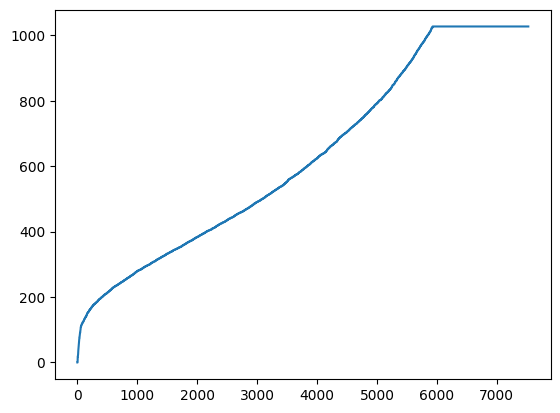

In [41]:
plt.plot(content_np[0:25000])

## 构造训练集和测试集

In [86]:
# 构造训练集和测试集
#通过文本切分的方式，按9：1 的方式来随机切分
df=sklearn.utils.shuffle(data) #随机打乱
train_data = df.sample(frac=0.9, random_state=0, axis=0)
dev_data = df[~df.index.isin(train_data.index)]

# #将训练数据写入到文件中
train_data.to_csv('train_data.csv',  index=False,encoding='utf-8',sep ='|',header =['id','content','abstract'])
# #将测试数据写入文件中
dev_data.to_csv('dev_data.csv',  index=False,encoding='utf-8',sep ='|',header =['id','content','abstract'])

In [64]:
data.to_csv('data_test.csv',  index=False,encoding='utf-8',sep ='|',header =['id','content'])

In [87]:
from paddlenlp.datasets import load_dataset

def read(data_path):
    with open(data_path, 'r', encoding='utf-8') as f:
        # 跳过列名
        next(f)
        for line in f:
            content, abstract = line.strip('\t').split("|")[1].strip(),line.strip('\t').split("|")[2].strip()
            content = line.strip('\t').split("|")[1].strip()
            abstract = line.strip('\t').split("|")[2].strip()
            
            yield {'content': content, 'abstract': abstract}

# data_path为read()方法的参数
train_dataset  = load_dataset(read, data_path='train_data.csv',lazy=False, split="train")
dev_dataset  = load_dataset(read, data_path='dev_data.csv',lazy=False, split="dev")
print(len(train_dataset))
print(len(dev_dataset))

D:\Program\Anaconda\envs\paddle\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


22501
2500


In [42]:
from paddlenlp.transformers import PegasusForConditionalGeneration, PegasusChineseTokenizer
from paddlenlp.transformers import LinearDecayWithWarmup
from paddle.io import BatchSampler, DistributedBatchSampler, DataLoader
from paddlenlp.data import DataCollatorForSeq2Seq

#创建Tokenizer，用于分词，将token映射成id。
1# 初始化分词器
tokenizer = PegasusChineseTokenizer.from_pretrained('IDEA-CCNL/Randeng-Pegasus-523M-Summary-Chinese')
# 初始化模型，'IDEA-CCNL/Randeng-Pegasus-238M-Summary-Chinese/'IDEA-CCNL/Randeng-Pegasus-538M-Summary-Chinese
model = PegasusForConditionalGeneration.from_pretrained('IDEA-CCNL/Randeng-Pegasus-523M-Summary-Chinese')
# 组装 Batch 数据 & Padding
batchify_fn = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

D:\Program\Anaconda\envs\paddle\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-05-24 23:46:08,947] [    INFO] - Already cached C:\Users\cyberloafing\.paddlenlp\models\IDEA-CCNL/Randeng-Pegasus-523M-Summary-Chinese\vocab.txt
[2023-05-24 23:46:08,949] [    INFO] - Already cached C:\Users\cyberloafing\.paddlenlp\models\IDEA-CCNL/Randeng-Pegasus-523M-Summary-Chinese\added_tokens.json
[2023-05-24 23:46:08,950] [    INFO] - Already cached C:\Users\cyberloafing\.paddlenlp\models\IDEA-CCNL/Randeng-Pegasus-523M-Summary-Chinese\special_tokens_map.json
[2023-05-24 23:46:08,951] [    INFO] - Already cached C:\Users\cyberloafing\.paddlenlp\models\IDEA-CCNL/Randeng-Pegasus-523M-Summary-Chinese\tokenizer_config.json
[2023-05-24 23:46:08,983] [    INFO] - Already cached C:\Users\cyberloafing\.paddlenlp\models\IDEA-CCNL/Randeng-Pegasus-523M-Summary-Chinese\model_state.pdparams
[2023-05-24 23:4

# 训练

In [45]:
#安装需要的相关库
import os
import json
import argparse
import random
import time
import paddle
import paddlenlp
import distutils.util
from pprint import pprint
from functools import partial
from tqdm import tqdm
import numpy as np
import math
from datasets import load_dataset
import contextlib
from rouge import Rouge
from visualdl import LogWriter


import pandas as pd 
from paddlenlp.datasets import MapDataset
import paddle.nn as nn
from paddlenlp.utils.log import logger
from paddlenlp.metrics import BLEU
from paddlenlp.data import Tuple, Pad

In [51]:
#定义convert_example，将content和title文本映射成int类型的id，同时构造labels。
def convert_example(example, text_column, summary_column, tokenizer,
                    max_source_length, max_target_length):
    """
    构造模型的输入.
    """
    inputs = example[text_column]
    targets = example[summary_column]
    # 分词
    model_inputs = tokenizer(inputs,
                             max_length=max_source_length,
                             padding=False,
                             truncation=True,
                             return_attention_mask=True)
    labels = tokenizer(targets,
                       max_length=max_target_length,
                       padding=False,
                       truncation=True)
    # 得到labels，后续通过DataCollatorForSeq2Seq进行移位
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [50]:
#由于预训练模型限制，这里把文本最大长度设置为1024
# 文本的最大长度
max_source_length = 1024
# 摘要的最大长度
max_target_length = 256
# 摘要的最小长度
min_target_length = 0

In [52]:
#使用partial函数指定默认参数，使用map函数转换数据。map函数把原来的文本根据词汇表的编号转换成了相应的id，为了便于理解，这里把训练集合的部分样本展示出来。
# 定义转换器
trans_func = partial(convert_example,
                     text_column='content',
                     summary_column='abstract',
                     tokenizer=tokenizer,
                     max_source_length=max_source_length,
                     max_target_length=max_target_length)
                     
# train_dataset和dev_dataset分别转换
train_dataset = train_dataset.map(trans_func,
                                  batched=False,
                                  lazy =False)

dev_dataset = dev_dataset.map(trans_func,
                              batched=False,
                            lazy =False)
# 输出训练集的前 2 条样本
# for idx, example in enumerate(train_dataset):
#     if idx < 2:
#         print(example)

NameError: name 'train_dataset' is not defined

In [94]:
train_data_loader  = paddle.io.DataLoader(
    dataset=train_dataset,
    batch_size=8,
    return_list=True,
    collate_fn=batchify_fn)
dev_batch_sampler  = BatchSampler(
    dataset=dev_dataset,
    batch_size=8,
    shuffle=False)

# 构造测试Dataloader
dev_data_loader = DataLoader(dataset=dev_dataset,
                             batch_sampler=dev_batch_sampler,
                             num_workers=0,
                             collate_fn=batchify_fn,
                             return_list=True)

## 训练配置

In [53]:
# 学习率预热比例
warmup = 0.02
# 学习率
learning_rate = 5e-5
# 训练轮次
num_epochs =30
# 训练总步数
num_training_steps = len(train_data_loader) * num_epochs
# AdamW优化器参数epsilon
adam_epsilon = 1e-6
# AdamW优化器参数weight_decay
weight_decay=0.01
# 训练中，每100个log_steps打印一次日志
log_steps = 100
# 训练中，每隔eval_steps进行一次模型评估
eval_steps = 10000

# 训练模型保存路径
output_dir = 'checkpoints'
# 解码beam size
num_beams = 4

log_writer = LogWriter('visualdl_log_dir')
lr_scheduler = LinearDecayWithWarmup(learning_rate, num_training_steps, warmup)

# LayerNorm参数不参与weight_decay
decay_params = [
    p.name for n, p in model.named_parameters()
    if not any(nd in n for nd in ["bias", "norm"])
]

# 优化器AdamW
optimizer = paddle.optimizer.AdamW(
    learning_rate=lr_scheduler,
    beta1=0.9,
    beta2=0.999,
    epsilon=adam_epsilon,
    parameters=model.parameters(),
    weight_decay=weight_decay,
    apply_decay_param_fun=lambda x: x in decay_params)

NameError: name 'train_data_loader' is not defined

In [96]:
# 计算训练评估参数Rouge-1，Rouge-2，Rouge-L
def compute_metrics(preds, targets):
    assert len(preds) == len(targets), (
        'The length of pred_responses should be equal to the length of '
        'target_responses. But received {} and {}.'.format(
            len(preds), len(targets)))
    rouge = Rouge()
    
    scores = []
    for pred, target in zip(preds, targets):
        try:
            score = rouge.get_scores(' '.join(pred), ' '.join(target))
            scores.append([
                score[0]['rouge-1']['f'], score[0]['rouge-2']['f'],
                score[0]['rouge-l']['f']
            ])
        except ValueError:
            scores.append([0, 0, 0])
    rouge1 = np.mean([i[0] for i in scores])
    rouge2 = np.mean([i[1] for i in scores])
    rougel = np.mean([i[2] for i in scores])
    
    print('\n' + '*' * 15)
    print('The auto evaluation result is:')
    print('rouge-1:', round(rouge1*100, 2))
    print('rouge-2:', round(rouge2*100, 2))
    print('rouge-L:', round(rougel*100, 2))
   
    return rouge1, rouge2, rougel

In [97]:
# 模型评估函数
@paddle.no_grad()
def evaluate(model, data_loader, tokenizer, min_target_length,
             max_target_length):
    model.eval()
    all_preds = []
    all_labels = []
    model = model._layers if isinstance(model, paddle.DataParallel) else model
    for batch in tqdm(data_loader, total=len(data_loader), desc="Eval step"):
        labels = batch.pop('labels').numpy()
        # 模型生成
        preds = model.generate(input_ids=batch['input_ids'],
                               attention_mask=batch['attention_mask'],
                               min_length=min_target_length,
                               max_length=max_target_length,
                               diversity_rate='beam_search',
                               num_beams=num_beams,
                               use_cache=True)[0]
        # tokenizer将id转为string
        all_preds.extend(
            tokenizer.batch_decode(preds.numpy(),
                                   skip_special_tokens=True,
                                   clean_up_tokenization_spaces=False))
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
        all_labels.extend(
            tokenizer.batch_decode(labels,
                                   skip_special_tokens=True,
                                   clean_up_tokenization_spaces=False))
    rouge1, rouge2, rougel= compute_metrics(all_preds, all_labels)
    model.train()
    return rouge1, rouge2, rougel

## 定义训练

In [98]:
def train(model, train_data_loader):
    eval_steps = 10000
    global_step = 0
    best_rougel = 0
    tic_train = time.time()
    for epoch in range(num_epochs):
        for step, batch in enumerate(train_data_loader):
            global_step += 1
            # 模型前向训练，计算loss
            lm_logits, _, loss = model(**batch)
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.clear_grad()
            if global_step % log_steps == 0:
                logger.info(
                    "global step %d/%d, epoch: %d, batch: %d, rank_id: %s, loss: %f, lr: %.10f, speed: %.4f step/s"
                    % (global_step, num_training_steps, epoch, step,
                        paddle.distributed.get_rank(), loss, optimizer.get_lr(),
                        log_steps / (time.time() - tic_train)))
                log_writer.add_scalar("train_loss", loss.numpy(), global_step)
                tic_train = time.time()
            if global_step > 60000:
                eval_steps = 3000
            if global_step % eval_steps == 0 or global_step == num_training_steps:
                tic_eval = time.time()
                rouge1, rouge2, rougel = evaluate(model, dev_data_loader, tokenizer,
                            min_target_length, max_target_length)
                logger.info("eval done total : %s s" % (time.time() - tic_eval))
                log_writer.add_scalar("eval_rouge1", rouge1, global_step)
                log_writer.add_scalar("eval_rouge2", rouge2, global_step)
                log_writer.add_scalar("eval_rougel", rougel, global_step)
                if best_rougel < rougel:
                    best_rougel = rougel
                    if paddle.distributed.get_rank() == 0:
                        if not os.path.exists(output_dir):
                            os.makedirs(output_dir)
                        # Need better way to get inner model of DataParallel
                        model_to_save = model._layers if isinstance(
                            model, paddle.DataParallel) else model
                        model_to_save.save_pretrained(output_dir)
                        tokenizer.save_pretrained(output_dir)

In [ ]:
# 调用模型训练
train(model, train_data_loader)

In [48]:
def infer(text, model, tokenizer):
    tokenized = tokenizer(text,
                          truncation=True,
                          max_length=max_source_length,
                          return_tensors='pd')
    preds, _ = model.generate(input_ids=tokenized['input_ids'],
                              max_length=130,
                              min_length=min_target_length,
                              decode_strategy='beam_search',
                              num_beams=num_beams)
    #print(tokenizer.decode(preds[0], skip_special_tokens=True, clean_up_tokenization_spaces=False))
    return(tokenizer.decode(preds[0], skip_special_tokens=True, clean_up_tokenization_spaces=False))
model.eval()
validation_data = data
text=validation_data.iat[0,1]

In [55]:
text

'客:我刚收到咱们话费通知的短信了，我看了一下说我上个月消费了二十一块多吧，有五元是我的包月费，剩下有16块多的其他的消费，我没有进行过任何的，我想查查什么费用坐:国内通话费0.15元，到达电话打了一分钟流量的话，应该是超出了一部分，用了15块9毛3的流量费客:我肯定没有用流量，因为我是退休在家，我家里有WIFI，一星之前我刚激活，根本连买菜都不用，流量是怎么出来的钱，你们这肯定有积分问题坐:用了五十五十九兆流量，扣了19块15块9毛7的费用客:59兆流量六块钱坐:电话那您对流量超出不认可的话可以给您进行上报反馈，后期会有专人给您回电处理客:他最后给我回电，我要求这返返费，因为我肯定没消费，比如说电话电话有过吗，你使过我电话吗，电话我也没打过，我家里人也没用，我们每个人都有手续坐:现在这边无法给您进行核实，只能看到您使用的超出您是没有使用的话，我这边给您记录上报，后期会有专人给您客:你给我上报余额，反正就这15块几吧，我肯定没花点钱，但是我绝对没用过，因为我就没出过门激活坐:那我这边给您记录上报，后期会有专人给您回复客:他什么时候联系我，还是直接就给我发短信'

In [60]:
num_beams = 4
#构造文件读取函数
def read_file(filename,num=2):
    lines = []
    with open(filename, 'r', encoding='utf-8') as f:
        next(f)
        if num==3:
            for line in f:
                lines.append({"id":line.split("|")[0].strip(),"content":line.split("|")[1].strip(),"abstract":line.split("|")[2].strip()})
        else:
            for line in f:
                lines.append({"id":line.split("|")[0].strip(),"content":line.split("|")[1].strip()})
    return lines
infer(text, model, tokenizer)

'一星之前我家里有wifi'

In [65]:
validation_file = "data_test.csv"

In [66]:
validation_lines=read_file(validation_file)

In [68]:
validation_lines[0]

{'id': '25001',
 'content': '客:我刚收到咱们话费通知的短信了，我看了一下说我上个月消费了二十一块多吧，有五元是我的包月费，剩下有16块多的其他的消费，我没有进行过任何的，我想查查什么费用坐:国内通话费0.15元，到达电话打了一分钟流量的话，应该是超出了一部分，用了15块9毛3的流量费客:我肯定没有用流量，因为我是退休在家，我家里有WIFI，一星之前我刚激活，根本连买菜都不用，流量是怎么出来的钱，你们这肯定有积分问题坐:用了五十五十九兆流量，扣了19块15块9毛7的费用客:59兆流量六块钱坐:电话那您对流量超出不认可的话可以给您进行上报反馈，后期会有专人给您回电处理客:他最后给我回电，我要求这返返费，因为我肯定没消费，比如说电话电话有过吗，你使过我电话吗，电话我也没打过，我家里人也没用，我们每个人都有手续坐:现在这边无法给您进行核实，只能看到您使用的超出您是没有使用的话，我这边给您记录上报，后期会有专人给您客:你给我上报余额，反正就这15块几吧，我肯定没花点钱，但是我绝对没用过，因为我就没出过门激活坐:那我这边给您记录上报，后期会有专人给您回复客:他什么时候联系我，还是直接就给我发短信'}

In [69]:
result_data=pd.DataFrame()
idx = 0
for line in validation_lines:
    idx +=1
    validation_id=line['id']
    content=line['content']
    ret=infer(content,model, tokenizer)
    result={"id":validation_id,"ret":ret}
    result_data=result_data._append(result,ignore_index=True)
    if idx % 100 == 0 or idx in [1,2,3,4,5,6]:
        print("数据生成进行中，当前进行ID：",validation_id)
result_data.to_csv('result.csv',  index=False,encoding='utf-8',sep ='|',header =['id','ret'])

数据生成进行中，当前进行ID： 25001
数据生成进行中，当前进行ID： 25002
数据生成进行中，当前进行ID： 25003
数据生成进行中，当前进行ID： 25004
数据生成进行中，当前进行ID： 25005
数据生成进行中，当前进行ID： 25006
数据生成进行中，当前进行ID： 25100
数据生成进行中，当前进行ID： 25200
数据生成进行中，当前进行ID： 25300
数据生成进行中，当前进行ID： 25400
数据生成进行中，当前进行ID： 25500
数据生成进行中，当前进行ID： 25600
数据生成进行中，当前进行ID： 25700
数据生成进行中，当前进行ID： 25800
数据生成进行中，当前进行ID： 25900
数据生成进行中，当前进行ID： 26000
数据生成进行中，当前进行ID： 26100
数据生成进行中，当前进行ID： 26200
数据生成进行中，当前进行ID： 26300
数据生成进行中，当前进行ID： 26400
数据生成进行中，当前进行ID： 26500
数据生成进行中，当前进行ID： 26600
数据生成进行中，当前进行ID： 26700
数据生成进行中，当前进行ID： 26800
数据生成进行中，当前进行ID： 26900
数据生成进行中，当前进行ID： 27000
数据生成进行中，当前进行ID： 27100
数据生成进行中，当前进行ID： 27200
数据生成进行中，当前进行ID： 27300
数据生成进行中，当前进行ID： 27400
数据生成进行中，当前进行ID： 27500
数据生成进行中，当前进行ID： 27600
数据生成进行中，当前进行ID： 27700
数据生成进行中，当前进行ID： 27800
数据生成进行中，当前进行ID： 27900
数据生成进行中，当前进行ID： 28000
数据生成进行中，当前进行ID： 28100
数据生成进行中，当前进行ID： 28200
数据生成进行中，当前进行ID： 28300
数据生成进行中，当前进行ID： 28400
数据生成进行中，当前进行ID： 28500
数据生成进行中，当前进行ID： 28600
数据生成进行中，当前进行ID： 28700
数据生成进行中，当前进行ID： 28800
数据生成进行中，当前进行ID： 28900
数据生成进行中，当前